In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os
import tifffile
from skimage.morphology import remove_small_objects

In [2]:
import tensorflow as tf
import sys
import glob
import Metrics
from tensorflow.keras.models import Model, load_model

2025-02-14 10:56:36.970606: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2025-02-14 10:56:36.970640: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=3,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [4]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = np.array(pred_mask[..., tf.newaxis])

    filtered_mid = remove_small_objects((pred_mask==1).astype(bool), min_size=100).astype(np.uint8)
    filtered_heads = remove_small_objects((pred_mask==2).astype(bool), min_size=50).astype(np.uint8)
    pred_mask = filtered_mid + filtered_heads * 2
    return pred_mask

In [5]:
def display(tiff, gt, pred):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    display_list = [tiff, gt, pred]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(np.array(display_list[i]), vmin=0, vmax=2)
        plt.axis('off')
    plt.show()

In [6]:
gt_head_files = glob.glob("../testimg/Heads/*.tif")
gt_mid_files = glob.glob("../testimg/Mid/*.tif")
tiff_files = glob.glob("../testimg/Tiffs/*.tif")

print(gt_head_files)
gt_heads, gt_mid, tiffs = [], [], []

for i in range(len(gt_head_files)):
    gt_heads.append(np.array(Image.open(gt_head_files[i])))
    gt_mid.append(np.array(Image.open(gt_mid_files[i])))
    tiffs.append(np.array(Image.open(tiff_files[i]))[:,:])

['../testimg/Heads/3_B6_caduaepi_ex740_int30_8_0.tif', '../testimg/Heads/Tg-_57091_ex740_HBSS_int30_14_1.tif']


In [7]:
gt_heads, gt_mid, tiffs = np.array(gt_heads), np.array(gt_mid), np.array(tiffs)
gt = np.zeros(gt_heads.shape)
gt[gt_heads > 0] = 2
gt[gt_mid > 0] = 1
tiffs = tiffs.astype(np.float32) / 255.
tiffs.shape

(2, 512, 512, 3)

In [8]:
model_name = "../model"

model = load_model(model_name, compile=False, custom_objects={"UpdatedMeanIoU": UpdatedMeanIoU()})
pred_masks = create_mask(model.predict(tiffs))
pred_masks = np.array(pred_masks)[:, :, :, 0]

2025-02-14 10:56:39.126775: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2025-02-14 10:56:39.253531: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-02-14 10:56:39.253586: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lola-Vivobook-Linux): /proc/driver/nvidia/version does not exist
2025-02-14 10:56:39.254860: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-14 10:56:39.264764: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3194175000 Hz
2025-02-14 10:56:39.266809: I 

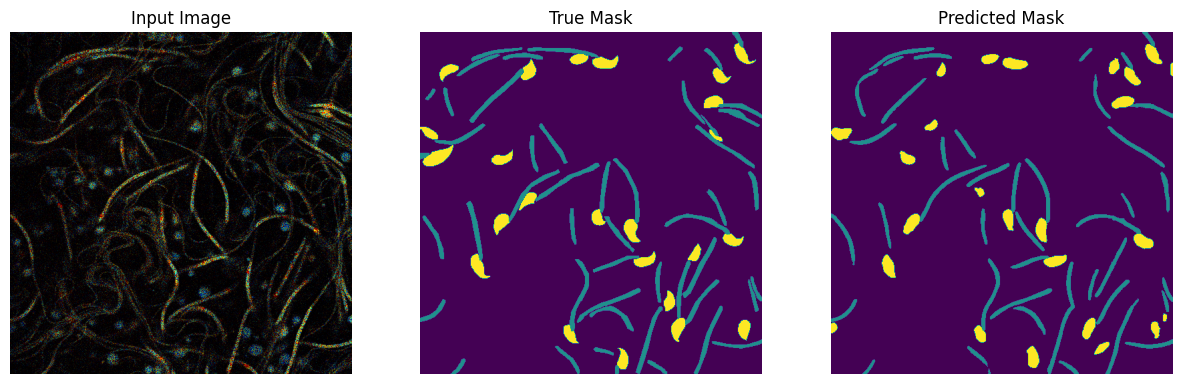

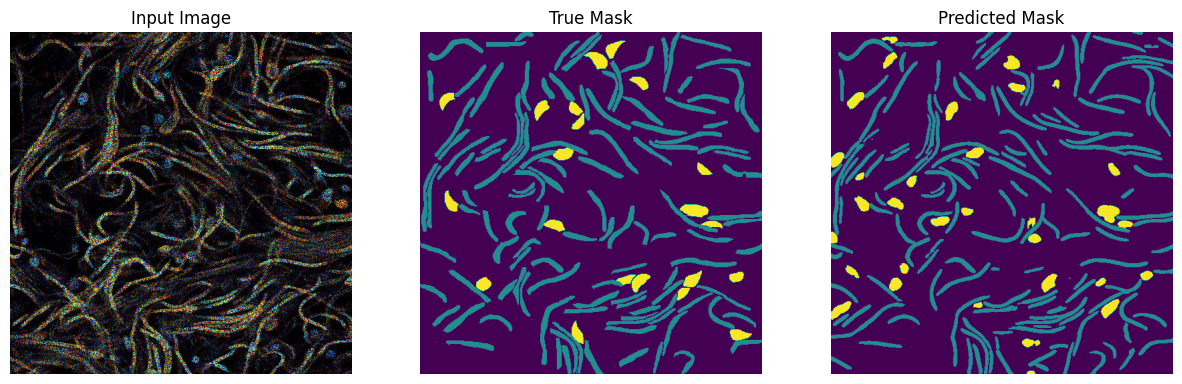

            IoU   Accuracy     Recall  Precision   F1-score
Mito  62.688300  94.482040  78.395062  79.375000  78.881988
Head  40.369525  97.260666  66.666667  52.631579  58.823529
All   57.530334  91.758919  75.845411  72.350230  74.056604
       TP  Detected   GT
Mito  127       160  162
Head   30        57   45
All   157       217  207


In [9]:
for p, g, t, filename in zip(pred_masks, gt, tiffs, tiff_files):
    display(t, g, p)
    name = filename.replace("Tiffs", "Predictions")
    try:
        os.makedirs(os.path.dirname(name), exist_ok=True)
    except OSError as error:
        print(error)
    tifffile.imwrite(name, p.astype(np.uint8))
    
m = Metrics.Metrics(gt, pred_masks, iou_thresh=0.4, verbal=True)
m